In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
import time

In [2]:
# Load data

with open("data/2022-08-02-01.json", "r") as file:
    data_text = file.read()
    data_dict = json.loads(data_text)
    data = np.array(data_dict["trace_array"])

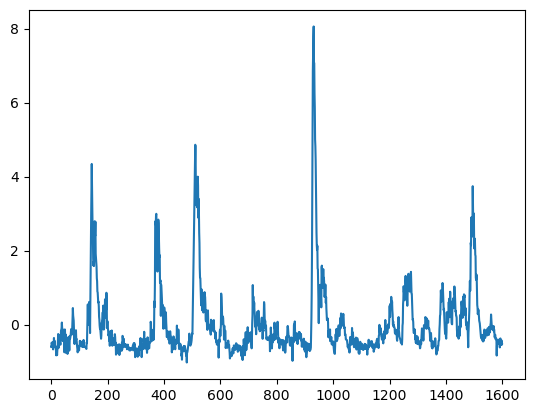

In [3]:
plt.plot(data[15])

In [4]:
152 * 20

3040

In [136]:
class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.first_layer = nn.Linear(3040, 500)
        self.first_act = nn.LeakyReLU()
        self.second_layer = nn.Linear(500, 152)
        self.second_act = nn.LeakyReLU()
        self.third_layer = nn.Linear(152, 152)
        self.third_act = nn.LeakyReLU()

        self.process = nn.Sequential(self.first_layer,
                                     self.first_act,
                                     self.second_layer,
                                     self.second_act,
                                     self.third_layer,
                                     self.third_act,
                                     nn.Linear(152, 152),
                                     nn.LeakyReLU(),
                                     nn.Linear(152, 152),
                                     nn.LeakyReLU(),
                                     nn.Linear(152, 152),
                                     nn.LeakyReLU(),
                                     nn.Linear(152, 152),
                                     nn.LeakyReLU(),)
        
        self.final_layer = nn.Linear(152, 152)

    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 3040))
        x = self.process(x)
        x = self.final_layer(x)
        return x

In [137]:
data.shape

(152, 1600)

In [138]:
# Window Sample

simple_x = []
simple_y = []

for i in range(1580):
    window = data[:, i:i+20]
    simple_x.append(window)
    simple_y.append(data[:, i+20])

simple_x = np.array(simple_x)
simple_y = np.array(simple_y)

In [139]:
x_train, x_test, y_train, y_test = train_test_split(simple_x, simple_y, test_size=0.2, random_state=5, shuffle=True)

In [140]:
x_train.shape, y_train.shape

((1264, 152, 20), (1264, 152))

In [141]:
def train(model, criterion, optimizer, points, labels, test_x, test_y, epoches=5, do_print=True):
    
    total_start_time = time.time()
    loss = -1
    for i in range(1,epoches+1):
        start_time = time.time()
        optimizer.zero_grad()
        y = model(points)
        loss = criterion(y, labels)
        loss.backward()
        optimizer.step()
        end_time = time.time()
        if(i % 50 == 0 and do_print):
            test_out = model(test_x)
            test_loss = criterion(test_out, test_y)
            print(f"{i}: Loss {loss.item()}, Test Loss {test_loss.item()}")
            
    total_end_time = time.time()
    total_time_taken = total_end_time - total_start_time
    if(do_print):
        print(f"Total Time {total_time_taken}")
        
    final_loss = loss.item()
    
    return (total_time_taken, final_loss)

In [142]:
# Training Setup

torch.manual_seed(4687)
model = SimpleNetwork()

optimiser = optim.Adam(model.parameters(), lr=0.001)
crit = nn.MSELoss()

x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

test_tensor = torch.from_numpy(x_test).float()
test_y_tensor = torch.from_numpy(y_test).float()

x_train_tensor.shape[0]

1264

In [147]:
time_taken, final_loss = train(model, crit, optimiser, x_train_tensor, y_train_tensor, test_tensor, test_y_tensor, epoches=350, do_print=True)

50: Loss 0.05958830937743187, Test Loss 0.18957898020744324
100: Loss 0.06368514150381088, Test Loss 0.19501060247421265
150: Loss 0.05533294007182121, Test Loss 0.18884265422821045
200: Loss 0.05534020811319351, Test Loss 0.18936674296855927
250: Loss 0.05513719096779823, Test Loss 0.1902490258216858
300: Loss 0.053436361253261566, Test Loss 0.190606027841568
350: Loss 0.051542263478040695, Test Loss 0.19069023430347443
Total Time 9.53571629524231


In [148]:
x_test_tensor = torch.from_numpy(simple_x).float()
output = model(x_test_tensor).detach().numpy()

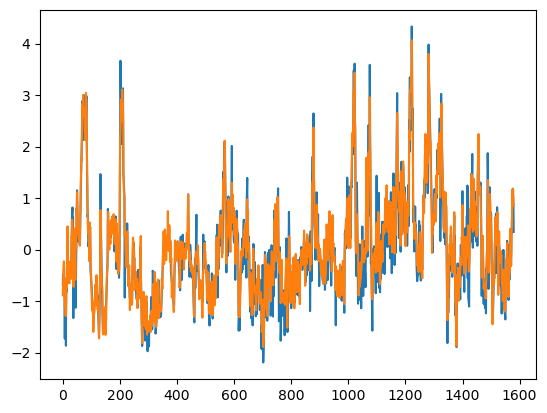

In [149]:
plt.plot(simple_y[:, 0])
plt.plot(output[:, 0])

In [150]:
output = model(test_tensor)

In [151]:
crit(test_y_tensor, output)

tensor(0.1907, grad_fn=<MseLossBackward0>)

In [152]:
# Far seeing / Close seeing

# Set window to 0 or -1 for different effect
window = simple_x[0]
window = window.reshape(1, 152, 20)

line = []

for i in range(1500):
    input = torch.from_numpy(window).float()
    out = model(input).detach().numpy().reshape(1, 152, 1)
    line.append(out)
    window = np.concatenate((window[:, :, 1:], out), axis=2) 

line = np.array(line).reshape(1500, 152)
ext_line = np.concatenate((simple_x[0].T, line), axis = 0).T
combined = np.concatenate((data.T, line), axis = 0).T
line = line.T

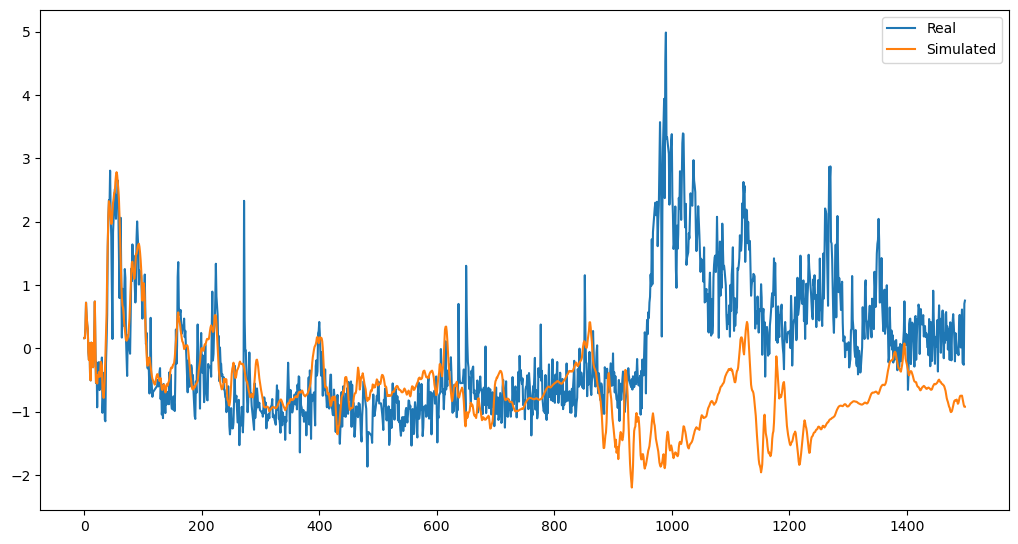

In [153]:
plt.plot(data[60, :1500], label="Real")
plt.plot(ext_line[60, :1500], label="Simulated")
fig = plt.gcf()
fig.set_size_inches(12.5, 6.5)
plt.legend(loc='best')
plt.show()

In [19]:
text = '''50: Loss 0.542038083076477, Test Loss 0.5256966948509216
100: Loss 0.4054592549800873, Test Loss 0.3994710445404053
150: Loss 0.31234702467918396, Test Loss 0.31763526797294617
200: Loss 0.2550389766693115, Test Loss 0.2693379819393158
250: Loss 0.21755757927894592, Test Loss 0.24038328230381012
300: Loss 0.18935471773147583, Test Loss 0.22041144967079163
350: Loss 0.1665990799665451, Test Loss 0.2061326652765274
400: Loss 0.14783909916877747, Test Loss 0.19608989357948303
450: Loss 0.13229107856750488, Test Loss 0.1895163506269455
500: Loss 0.11910996586084366, Test Loss 0.18527695536613464
550: Loss 0.10766829550266266, Test Loss 0.1821182519197464
600: Loss 0.0978560596704483, Test Loss 0.18114329874515533
650: Loss 0.08961444348096848, Test Loss 0.18042030930519104
700: Loss 0.08156861364841461, Test Loss 0.17997589707374573
750: Loss 0.07496180385351181, Test Loss 0.18021813035011292
800: Loss 0.06915687769651413, Test Loss 0.18081150949001312
850: Loss 0.0639190673828125, Test Loss 0.18156787753105164
900: Loss 0.05974731221795082, Test Loss 0.1831955760717392
950: Loss 0.05518801510334015, Test Loss 0.18331597745418549
1000: Loss 0.051656026393175125, Test Loss 0.18429192900657654
1050: Loss 0.04848547279834747, Test Loss 0.18667685985565186
1100: Loss 0.04552420973777771, Test Loss 0.18853512406349182
1150: Loss 0.04479101672768593, Test Loss 0.19013947248458862
1200: Loss 0.04012039303779602, Test Loss 0.19091692566871643
1250: Loss 0.04015333577990532, Test Loss 0.19104483723640442
1300: Loss 0.035501331090927124, Test Loss 0.19275297224521637
1350: Loss 0.03422030061483383, Test Loss 0.19337064027786255
1400: Loss 0.031919099390506744, Test Loss 0.19534169137477875
1450: Loss 0.03047347441315651, Test Loss 0.19641759991645813
1500: Loss 0.03293424844741821, Test Loss 0.20257531106472015
1550: Loss 0.027387991547584534, Test Loss 0.19908273220062256
1600: Loss 0.026105791330337524, Test Loss 0.20012858510017395
1650: Loss 0.025347387418150902, Test Loss 0.20099873840808868
1700: Loss 0.02372319996356964, Test Loss 0.20310086011886597
1750: Loss 0.023021327331662178, Test Loss 0.20501384139060974
1800: Loss 0.02626599185168743, Test Loss 0.20874105393886566
1850: Loss 0.021335197612643242, Test Loss 0.20615136623382568
1900: Loss 0.02012675255537033, Test Loss 0.20741599798202515
1950: Loss 0.019542086869478226, Test Loss 0.20887860655784607
2000: Loss 0.018368931487202644, Test Loss 0.20932257175445557'''

In [20]:
split_lines = text.split("\n")

In [21]:
split = [a.split("Loss") for a in split_lines]

In [22]:
split

[['50: ', ' 0.542038083076477, Test ', ' 0.5256966948509216'],
 ['100: ', ' 0.4054592549800873, Test ', ' 0.3994710445404053'],
 ['150: ', ' 0.31234702467918396, Test ', ' 0.31763526797294617'],
 ['200: ', ' 0.2550389766693115, Test ', ' 0.2693379819393158'],
 ['250: ', ' 0.21755757927894592, Test ', ' 0.24038328230381012'],
 ['300: ', ' 0.18935471773147583, Test ', ' 0.22041144967079163'],
 ['350: ', ' 0.1665990799665451, Test ', ' 0.2061326652765274'],
 ['400: ', ' 0.14783909916877747, Test ', ' 0.19608989357948303'],
 ['450: ', ' 0.13229107856750488, Test ', ' 0.1895163506269455'],
 ['500: ', ' 0.11910996586084366, Test ', ' 0.18527695536613464'],
 ['550: ', ' 0.10766829550266266, Test ', ' 0.1821182519197464'],
 ['600: ', ' 0.0978560596704483, Test ', ' 0.18114329874515533'],
 ['650: ', ' 0.08961444348096848, Test ', ' 0.18042030930519104'],
 ['700: ', ' 0.08156861364841461, Test ', ' 0.17997589707374573'],
 ['750: ', ' 0.07496180385351181, Test ', ' 0.18021813035011292'],
 ['800: 

In [23]:
numbers = [ a[1:] for a in split]

In [24]:
numbers = [ [float(a.replace(", Test", "").strip()) for a in b] for b in numbers]

In [25]:
numbers = np.array(numbers)

In [26]:
numbers[:, 0]

array([0.54203808, 0.40545925, 0.31234702, 0.25503898, 0.21755758,
       0.18935472, 0.16659908, 0.1478391 , 0.13229108, 0.11910997,
       0.1076683 , 0.09785606, 0.08961444, 0.08156861, 0.0749618 ,
       0.06915688, 0.06391907, 0.05974731, 0.05518802, 0.05165603,
       0.04848547, 0.04552421, 0.04479102, 0.04012039, 0.04015334,
       0.03550133, 0.0342203 , 0.0319191 , 0.03047347, 0.03293425,
       0.02738799, 0.02610579, 0.02534739, 0.0237232 , 0.02302133,
       0.02626599, 0.0213352 , 0.02012675, 0.01954209, 0.01836893])

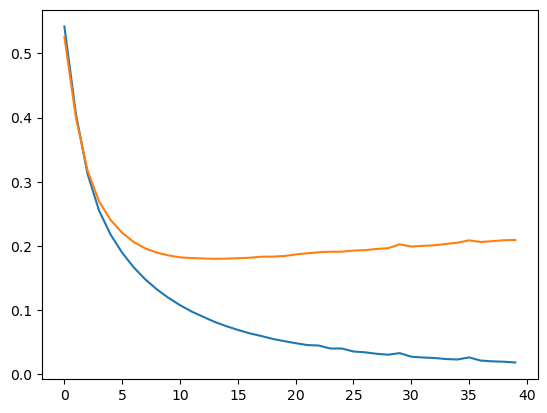

In [27]:
plt.plot(numbers[:, 0])
plt.plot(numbers[:, 1])